In [1]:
# since this dataset is so well known we can download it with scikit-learn
from sklearn.datasets import fetch_openml 
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
# Scikit-Learn datasets already have a data, target, and DESCR keys, in a dictionary structure
X, y = mnist["data"], mnist["target"] 
X.shape
y.shape

(70000,)

In [3]:
# looking at the pixels from one example in the data
import matplotlib as mpl 
import matplotlib.pyplot as plt 
some_digit = X[0] 
some_digit_image = some_digit.reshape(28, 28) 
plt.imshow(some_digit_image, cmap ="binary") 
plt.axis("off") 
plt.show()

<Figure size 640x480 with 1 Axes>

In [4]:
y[0] # X[0] is indeed a 5

'5'

In [5]:
#the dataset already came pre-split into training(first 60k images) and testing set(last 10k images) and is shuffled already
import numpy as np
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
y_train_5 = (y_train==5) # True for all 5s, False for all other digits
y_test_5 = (y_test==5)

In [7]:
# Train using a Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

In [9]:
# evaluating performance of SGDClassifier model using K-fold cross-validation with three folds
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
# look at dumb classifier that classifies every single image as being in the "not-5" class to compare to SGDClassifier
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# Is right most of the time because 90% of images aren't 5

array([0.91125, 0.90855, 0.90915])

In [11]:
# A better way to evaluate performance is with confusion matrix; 
# Use cross-validation with K-fold to return predictions on each fold (Trains and predicts fresh on each set of folds)
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [12]:
# get confusion matrix by passing confusion_matrix() the target classes, y_train_5, and the predicted classes, y_train_pred
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
# Top row is non-5s, second row are 5s
# top left is true-negatives (53892),    top right is false-positives (687)
# bottom left is false-negatives (1891),  bottom right is true-positives (3530)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [13]:
# Example of perfect classifiers confusion matrix; Would only have true positives and true negatives
y_train_perfect_predictions = y_train_5 #pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier

>`precision = TP/TP+FP`  TP is True-Positive & FP is False-Positive

Precision is typically used along with another metric named *recall*, also called *sensitivity* or the *true positive rate* (TPR): this is the ratio of positive instances that are correctly detected by the classifier

>`recall=TP/TP+FN`  TP is True-Positive & FN is False-Negatives

<img src="images/confusion_matrix_illustrated.png">

In [14]:
# computer precision and recall
from sklearn.metrics import precision_score, recall_score
print("Precision: ", precision_score(y_train_5, y_train_pred))
print("Recall: ", recall_score(y_train_5, y_train_pred))
# when 5-detector claims image is 5 it is correct 83.7% of the time.
# 5-detector only detects 65% of the 5s

Precision:  0.8370879772350012
Recall:  0.6511713705958311


Combining precision and recall into one metric would result in a *F1 Score*, the Harmonic mean of precision and recall (gives more weight to low values. 
>`F1 = 2 / [(1 / precision) + (1 / recall)] = 2 * [(precision * recall) / (precision + recall)] = TP / [TP + ((FN + FP) / 2)]

In [15]:
# Compute the F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
# F1 score favors classifiers with similar precision and recall, but sometimes you want more precision or more recall

0.7325171197343846

Precision/Recall tradeoff:
<img src="images/precision_recall_tradeoff_illustrated.png">

In [16]:
# use decision_function instead of predict() to control the threshold
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
# SGDClassifier uses a threshold=0; so this is the same as the previous code
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[2164.22030239]


array([ True])

In [17]:
# if we raise the threshold to 8000
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# raising the threshold decreases recall; so even though the image is a 5 the classifier misses it when threshold is high

array([False])

In [18]:
# to know which threshold to use first use cross_val_predict to get scores of all instances in training set
# specify that this time we want it to return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# Now use these scores with the precision_recall_curve function to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

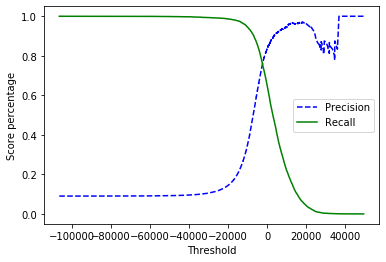

In [19]:
# use Matplotlib to plot precision and recall as functions of threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Threshold')
    plt.ylabel('Score percentage')
    [...] # highlight the threshold and add the legend, axis, and grid    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend(loc="best")
plt.show()

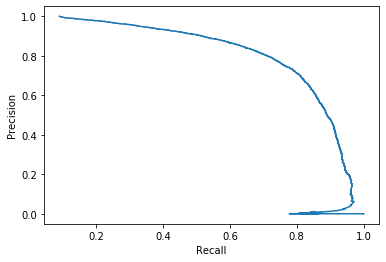

In [20]:
# we can also plot precision directly against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(precisions[:-1], recalls[:-1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    [...] # highlight the threshold and add the legend, axis, and grid    
plot_precision_vs_recall(precisions, recalls)
plt.show()
# You can see that precision starts to fall sharply around 80% recall; 
# So you'd want to select a precision/recall tradeoff just before that drop - ex. 60% recall 

In [21]:
# to find the lowest threshold that gives you 90% precision
# np.argmax() will give you the first index of the maximum value, which in this case means first True value
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))
# Now we can find any precision we want, but the recall will suffer if precision is too high

Precision:  0.9000345901072293
Recall:  0.4799852425751706


In [22]:
# plot the ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

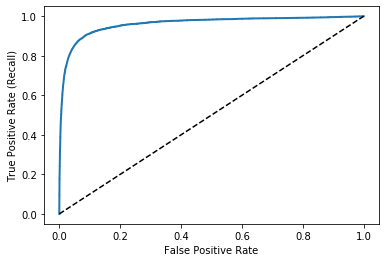

In [23]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal line
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate')
    [...] # highlight the threshold and add the legend, axis, and grid    
plot_roc_curve(fpr, tpr)
plt.show()
# The dashed line represents the ROC curve of a purely random classifier; 
#a good classifier stays as far away from that line as possible (toward the top-left corner). 
# the trade off here is: the higher the recall (TPR), the more false positives (FPR) the classifier produces. 

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

In [24]:
# Scikit-Learn provides a function to compute the ROC AUC: 
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [25]:
# train a RandomForestClassifier for comparison; Must use predict_proba() instead of decision_function()
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

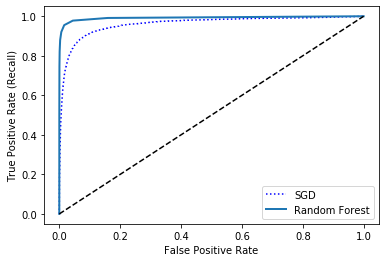

In [27]:
# plot the roc curve and compare curves
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()
# ROC curve of Random Forest is much better then SGD

In [28]:
# score is also better
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

# MultiClass Classification

In [29]:
# train a Support Vector Machine Classifier on the training set using the original target classes from 0-9 then predict
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42, verbose=True)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])
# under the hood this uses OvO strategy

[LibSVM]

array([5], dtype=uint8)

In [30]:
# use the decision function to return 10 scores per instance, one per class
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [31]:
# highest score is one corresponding to 5:
np.argmax(some_digit_scores)

5

In [32]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [33]:
svm_clf.classes_[5]

5

In [34]:
# you can force scikit-learn to use OvR or OvO by using either the OneVsOneClassifier or OneVsRestClassifier classes.
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [35]:
len(ovr_clf.estimators_)

10

In [36]:
# training a SGDClassifier is easy
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. The decision_function() method now returns one value per class. 

In [37]:
# Takes a while

# Let’s look at the score that the SGD classifier assigned to each class:
sgd_clf.decision_function([some_digit]) 
# You can see that the classifier is fairly confident about its prediction: 
#almost all scores are largely negative, while class 5 has a score of 2412.5. 
#The model has a slight doubt regarding class 3, which gets a score of 573.5.

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [38]:
#Takes a while

# Now we evaluate this classifier by using cross validation
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=10)
# it gets 84% on all test folds, not bad

array([0.87082583, 0.87089354, 0.88628294])

In [40]:
#Takes a while

# scaling the imputs increases accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", verbose=10, n_jobs=-1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


KeyboardInterrupt: 

# Error Analysis 
If this were a real project, you would now follow the steps in your Machine Learning project checklist (see Appendix   B). You’d explore data preparation options, try out multiple models (shortlisting the best ones and fine-tuning their hyperparameters using GridSearchCV), and automate as much as possible.
Here we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

In [ ]:
#Takes a while

# first we look at the confusion matrix
# by setting n_jobs=-1 you can use all cores, if you set to 1 you use 1 core, ect.
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, verbose=10, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
# it's clearer to look an image representation instead:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. 

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad):

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill the diagonal with zeros to keep only the errors, and plot the results:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

You can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused (in both directions).

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let’s plot examples of 3s and 5s (the plot_digits() function just uses Matplotlib’s imshow() function; see this chapter’s Jupyter notebook for details):

In [41]:
# EXTRA 
# (the plot_digits() function just uses Matplotlib’s imshow() function; 
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
    
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

ZeroDivisionError: integer division or modulo by zero

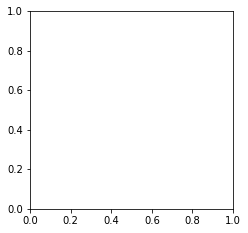

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

...
So one way to reduce the 3/ 5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.

# Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is called a *multilabel classification system*. 

In [43]:
# here is a simpler example for illustration:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9), and the second indicates whether or not it is odd. The next lines create a KNeighborsClassifier instance (which supports multilabel classification, though not all classifiers do), and we train it using the multiple targets array.

In [44]:
# Now you can make a prediction, and notice that it outputs two labels:
knn_clf.predict([some_digit])
# correct. The digit 5 is indeed not large (False) and odd (True). 

array([[False,  True]])

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score.

In [ ]:
#Takes a while

# This code computes the average F1 score across all labels:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, verbose=10, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

This assumes that all labels are equally important, however, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average =" weighted" in the preceding code.

# Multioutput Classification

The last type of classification task we are going to discuss here is called multioutput– multiclass classification (or simply multioutput classification). It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy’s randint() function. The target images will be the original images:

In [45]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [46]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

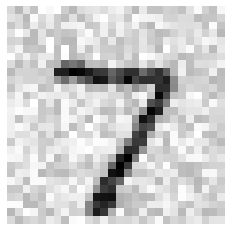

In [47]:
some_index=0
plot_digit(X_test_mod[0])

In [49]:
# train the classifier and make it clean these noisy images

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

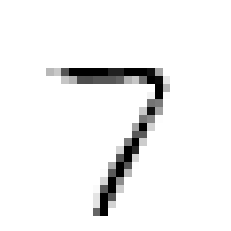

In [50]:
plot_digit(clean_digit)

In [ ]:
# save session - erroring
import dill
dill.dump_session('notebook_env.db')

In [ ]:
# reload session
import dill
dill.load_session('notebook_env.db')

# 1. 
Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [85]:
# TAKES Hour(s)

knn_clf = KNeighborsClassifier()

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 6 (2×3) combinations of hyperparameters
    {'weights': ["uniform", "distance"], 'n_neighbors': [2, 4, 6]},
  ]

# train across 5 folds, that's a total of (6)*5=30 rounds of training 
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 74.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 103.8min remaining: 11.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 116.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_neighbors': [2, 4, 6],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [86]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [87]:
grid_search.best_score_

0.9716166666666667

In [88]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

# 2.
Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called *data augmentation* or *training set expansion*.

In [51]:
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

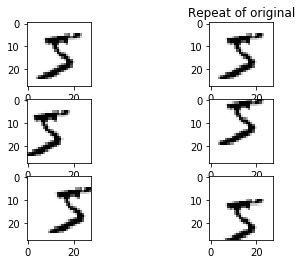

In [84]:
image = X_train[0]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)
shifted_image_up = shift_image(image, 0, -5)
shifted_image_right = shift_image(image, 5, 0)

fig, axs = plt.subplots(3, 2)
axs[0,0].imshow(image.reshape(28,28), interpolation="nearest", cmap="Greys")

axs[0,1].imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
axs[0,1].set_title("Repeat of original")

axs[1,0].imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")

axs[1,1].imshow(shifted_image_up.reshape(28, 28), interpolation="nearest", cmap="Greys")

axs[2,0].imshow(shifted_image_right.reshape(28, 28), interpolation="nearest", cmap="Greys")

axs[2,1].imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [89]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [90]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [91]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [92]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [93]:
# Takes a while

y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

# 3.
Tackle the Titanic dataset. A great place to start is on Kaggle.

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

First, login to [Kaggle](https://www.kaggle.com/) and go to the [Titanic challenge](https://www.kaggle.com/c/titanic) to download `train.csv` and `test.csv`. Save them to the `datasets/titanic` directory.

In [2]:
# load data 
import os
TITANIC_PATH = os.path.join("datasets", "titanic")

import pandas as pd
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

In [4]:
# check what data is missing/Null
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# numerical attributes
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# target attributes for survived
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
# categorical attributes
print("Pclass:\n", train_data["Pclass"].value_counts())
print("\nSex:\n", train_data["Sex"].value_counts())
print("\nEmbarked:\n", train_data["Embarked"].value_counts())

#The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Pclass:
 3    491
1    216
2    184
Name: Pclass, dtype: int64

Sex:
 male      577
female    314
Name: Sex, dtype: int64

Embarked:
 S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [8]:
# preprocessing data with a pipeline; Transformer will select a subset of the Pandas dataframe columns

# Here we are making a class to select either numerical or categorical columns
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [9]:
# here we are making a pipeline for the numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])
# also here we build a imputer to turn text attributes into numerical but it doesn't work on string categorical attributes

In [10]:
# Here we use the numerical pipeline
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [11]:
# build a imputer to turn those categorical attributes into numerical

# Here we are making a class to select the categorical attributes
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [12]:
# here we make a pipeline to select and transform the categorical attributes into numerical ones
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [13]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [14]:
# we can make a pipeline that runs both the cat_pipeline and the num_pipeline on our data using FeatureUnion
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Resulting functionality: We have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [15]:
X_train = preprocess_pipeline.fit_transform(train_data)
# our features
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [16]:
# our labels
y_train = train_data["Survived"]

We are training a classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10, n_jobs=-1, verbose=10)
forest_scores.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.3s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


0.8227176256951537

In [20]:
final_forest_clf = forest_clf.fit(X_train, y_train)

In [21]:
X_test = preprocess_pipeline.fit_transform(test_data)
X_test

array([[34.5,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       [47. ,  1. ,  0. , ...,  0. ,  0. ,  1. ],
       [62. ,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       ...,
       [38.5,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [27. ,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [27. ,  1. ,  1. , ...,  1. ,  0. ,  0. ]])

In [22]:
predictions = final_forest_clf.predict(X_test)

In [23]:
# Can't see how it went because survived wasn't included in test set
#y_test = test_data["Survived"]
#accuracy_score(y_test, predictions)

# after submitting to kaggle the accuracy on test set was 0.78708

In [24]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_titanic_predictions.csv', index=False)

# 4.
Build a spam classifier (a more challenging exercise):

Download examples of spam and ham from Apache SpamAssassin’s public datasets.

In [160]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()
fetch_spam_data()

Unzip the datasets and familiarize yourself with the data format.

In [161]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [163]:
len(ham_filenames)

2500

In [164]:
len(spam_filenames)

500

In [165]:
# parse emails
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [168]:
# now we have just the emails themselves
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [167]:
# looking at different email structures
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [169]:
# function to say how many structures are in given email
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [170]:
# how many structures are in ham_emails
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [171]:
# how many structures are in spam_emails
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

Split the datasets into a training set and a test set.

In [210]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. 
For example, if all emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1] (meaning [“ Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word. 
You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this). 

In [211]:
from bs4 import BeautifulSoup
import re

def html_to_plain_text(html):
    html = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    html = re.sub(r'(\s*\n)+', '\n', html, flags=re.M | re.S)
    soup = BeautifulSoup(html, 'lxml')
    text = soup.text    
    return text. rstrip('\n')

In [195]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [196]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")




OTC

 Newsletter
Discover Tomorrow's Winners 

For Immediate Release

Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.

REASONS TO INVEST IN CBYI

A profitable company and is on track to beat ALL earnings estimates!

One of the FASTEST growing distributors in environmental & safety equipment instruments.

Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.

RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as

In [197]:
# this is a function that takes an email as input and returns its content as plain text, whatever its format is
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [198]:
print(email_to_text(sample_html_spam)[:100], "...")




OTC

 Newsletter
Discover Tomorrow's Winners 

For Immediate Release

Cal-Bay (Stock Symbol: CBYI ...


In [202]:
# setting up stemming to be able to get each word to its base form

import nltk

stemmer = nltk.PorterStemmer()
# testing functionality of stemming
for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [203]:
# setting up url extractor to extract urls from text
import urlextract
    
url_extractor = urlextract.URLExtract()
# testing functionality of url extracter
print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [204]:
# this tranformer will count the amount of each word in an email, parsing the sentences and everything in order to do so

from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [206]:
# testing the transformer
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [207]:
# transformer to conver word counts to vectors, resulting in a sparse matrix
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [209]:
# testing transformer 
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int32)

What does this matrix mean? Well, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [213]:
# shows the words and their ranking from most often occurring to least
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [218]:
# transforming the whole data set

from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)
X_train_transformed

<2400x1001 sparse matrix of type '<class 'numpy.int32'>'
	with 188399 stored elements in Compressed Sparse Row format>

Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.

In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=10, n_jobs=-1)
score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


0.9854166666666666

In [220]:
# now applying the model to the test set, after transforming the test set
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 93.00%
Recall: 97.89%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [221]:
roc_auc_score(y_test, y_pred)

0.9825429911412193

In [222]:
f1_score(y_test, y_pred)

0.9538461538461539